#Des fonctions utiles


In [ ]:
from glob import glob
from natsort import natsorted
import os
import numpy as np 
import tensorflow as tf
''' 
  Le module Functools est destiné aux fonctions d'ordre supérieur qui fonctionnent sur d'autres fonctions. 
	Il fournit des fonctions pour travailler avec d'autres fonctions et des objets appelables pour les utiliser
     ou les étendre sans les réécrire complètement.
'''
import functools
#Generating 3D plots
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

batch_size = 16

''' cat_dict['bathtub'] = 0 // path : string 
    X : Load arrays or pickled objects from .npy, .npz or pickled files
    Y : indices des labels
'''
def fetch_data(path, cat_dict):
	path = path.numpy().decode('utf-8') 
	X    = np.load(path)
	Y    = cat_dict[path.split(os.path.sep)[1]]
	return X, Y
'''
  path :list des noms des fichier .npy
  The batch size defines the number of samples that will be propagated through the network.
'''
def load_batch(path, batch_size=16):
	return tf.data.Dataset.from_tensor_slices((path)).shuffle(len(path)).batch(batch_size, drop_remainder=True)
'''
'''
def load_data(path, cat_dict):
	X, Y = list(zip(*map(functools.partial(fetch_data, cat_dict=cat_dict), path)))
	X    = tf.convert_to_tensor(X, dtype='float32')
	Y    = tf.convert_to_tensor(Y, dtype='int32')
	return X, Y

def view_data(X, Y, cat_dict, rev_cat_dict):
	if not os.path.isdir('save_fig'):
		os.makedirs('save_fig')

	for idx, (shape, cat) in enumerate(zip(X, Y)):
		shape = shape.numpy()
		cat   = cat.numpy()
		ax    = plt.axes(projection='3d')
		ax.scatter3D(shape[:, 0], shape[:, 1], shape[:, 2])
		plt.title('Category: {0}'.format(rev_cat_dict[cat]))
		plt.savefig('save_fig/{0}.png'.format(idx))

def view_results(model, latent_dim, batch_size, categ, fileno):
	if not os.path.isdir('results'):
		os.makedirs('results/train/')
		os.makedirs('results/val/')
	idx   = np.random.randint(0, batch_size-1)
	tree  = [tf.random.uniform(shape=[batch_size, 1, latent_dim])]
	X     = model.gen(tree, training=False)[idx]
	ax    = plt.axes(projection='3d')
	ax.scatter3D(X[:, 0], X[:, 1], X[:, 2])
	plt.savefig('results/{0}/{1}.png'.format(categ, fileno))
	return X

#Les fonctions de pertes

In [ ]:
#Si la prédiction du modèle est parfaite, la perte (loss) est nulle ; sinon, la perte est plus importante.
import tensorflow as tf

def gen_loss(D_fake):
	return -tf.reduce_mean(D_fake)

def critic_loss_gp(D_real, D_fake, Y, Y_cap, model, batch_size):
	dloss = tf.reduce_mean(D_fake) - tf.reduce_mean(D_real)
	lam   = 10
	eps   = tf.random.uniform(shape=[batch_size, 1, 1], minval=0, maxval=1)
	x_cap = eps * Y + (1-eps) * Y_cap
	with tf.GradientTape() as gptape:
		gptape.watch(x_cap)
		out = model.critic(x_cap, training=True)
	grad = gptape.gradient(out, x_cap)[0]
	grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[0, 1]))
	grad_pen  = tf.reduce_mean((grad_norm - 1.0)**2)
	dloss = dloss + lam * grad_pen
	return dloss

#Le model

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, layers 

In [ ]:
# Tree-structured Graph Convolution Network
class TreeGCN(Model):
	def __init__(self, depth, child_node, degrees, filters, K=10, batch_size=8, upsample=True, activation=True):
		super(TreeGCN, self).__init__()
		self.depth         = depth
		self.batch_size    = batch_size
		self.child_node    = child_node
		self.input_feat    = filters[depth]
		self.out_feat      = filters[depth+1]
		self.degree        = degrees[depth]
		self.upsample      = upsample
		self.activation    = activation
		self.F_K           = [layers.Dense(units=K * self.input_feat), layers.Dense(units=self.out_feat)] # Loop
		self.W_A           = [layers.Dense(units=self.out_feat) for i in range(depth+1)] # Ancestor weights
		self.b             = tf.Variable(tf.initializers.GlorotUniform()(shape=[1, self.degree, self.out_feat]), name='Bias') # Xavier Initalization
		self.W_upsample    = tf.Variable(tf.initializers.GlorotUniform()(shape=[child_node, self.input_feat, self.degree*self.input_feat]), name='WeightMat') # Xavier Initalization
		self.act           = layers.LeakyReLU(alpha=0.2)

	def call(self, tree):
		Gath = 0 # Use for information gathering
		# Step 1: Accumulate information from ancestor
		for layer_no in range(self.depth+1):
			anc_node   = tree[layer_no].shape[1]
			repeat_num = self.child_node // anc_node
			Q          = self.W_A[layer_no](tree[layer_no]) # Ancestors
			# print(layer_no, anc_node, self.child_node, repeat_num, tree[layer_no].shape, Q.shape, end=' ')
			Gath       = Gath + tf.reshape(tf.tile(Q, [1, 1, repeat_num]), [self.batch_size, -1, self.out_feat]) # Gathering all the information
			# print(Gath.shape)
		# Step 2: Upsample the tree and Pass it through loop
		next_level = 0 # Next level for tree
		if self.upsample:
			next_level = tf.expand_dims(tree[-1], axis=2) @ self.W_upsample
			next_level = self.act(next_level)
			next_level = tf.reshape(next_level, [self.batch_size, self.child_node*self.degree, self.input_feat])
			next_level = self.F_K[1]( self.F_K[0]( next_level ) )
			next_level = next_level + tf.reshape(tf.tile(Gath, [1, 1, self.degree]), [self.batch_size, -1, self.out_feat])
		else:
			next_level = self.F_K[1]( self.F_K[0]( tree[-1] ) )
			next_level = next_level + Gath
		# Step 3: Add bias and Pass it through Activation function
		if self.activation:
			#
			next_level = self.act(next_level + tf.tile(self.b, [1, self.child_node, 1]))
		tree.append(next_level)
		return tree


In [ ]:
class Generator(Model):
	def __init__(self, K=10, latent_dim=96, batch_size=8):
		super(Generator, self).__init__()
		filters         = [latent_dim, 256, 256, 256, 128, 128, 128,  3]
		degrees         = [         1,   2,   2,   2,   2,   2,  64]
		self.depth      = len(filters) - 1
		self.tree_layer = []
		child_node      = 1
		for layer_no in range(self.depth):
			if layer_no == self.depth-1:
				self.tree_layer.append(TreeGCN(layer_no, child_node, degrees, filters, K=K, batch_size=batch_size, upsample=True, activation=False))
			else:
				self.tree_layer.append(TreeGCN(layer_no, child_node, degrees, filters, K=K, batch_size=batch_size, upsample=True, activation=True))
			child_node  = child_node * degrees[layer_no]

	def call(self, tree):
		for layer_no in range(self.depth):
			tree = self.tree_layer[layer_no]( tree )
		return tree[-1]

In [ ]:
class Critic(Model):
	def __init__(self):
		super(Critic, self).__init__()
		filters          = [3, 64,128,256,512,1024]
		units            = [128, 64]
		self.cnn_depth   = len(filters)
		self.fc_depth    = len(units)
		self.cnn_conv    = [layers.Conv1D(filters=filters[i], kernel_size=1, strides=1, padding='same') for i in range(self.cnn_depth)]
		self.cnn_act     = [layers.LeakyReLU(alpha=0.2) for _ in range(self.cnn_depth)]
		self.global_pool = layers.GlobalMaxPooling1D()
		self.flat        = layers.Flatten()
		self.fc          = [layers.Dense(units=units[i]) for i in range(self.fc_depth)]
		#f(x) = alpha *x if x<0 ;f(x) if x>=0
		self.fc_act      = [layers.LeakyReLU(alpha=0.2) for _ in range(self.fc_depth)]
		self.fc_final    = layers.Dense(units=1)

	def call(self, x):
		for layer_no in range(self.cnn_depth):
			x = self.cnn_act[layer_no]( self.cnn_conv[layer_no]( x ) )
		x = self.global_pool(x)
		x = self.flat(x)
		for layer_no in range(self.fc_depth):
			x = self.fc_act[layer_no]( self.fc[layer_no]( x ) )
		x = self.fc_final(x)
		return x

In [ ]:
class TreeGAN(Model):
	def __init__(self, K=10, latent_dim=96, batch_size=8):
		super(TreeGAN, self).__init__()
	  #Generator
		self.gen    = Generator(K=K, latent_dim=latent_dim, batch_size=batch_size)
	  #Critic
		self.critic = Critic()

def train_step(model, gen_opt, critic_opt, X, latent_dim, batch_size):
	critic_train = 5
	for _ in range(critic_train):
		with tf.GradientTape() as ctape:
			tree       = [tf.random.uniform(shape=[batch_size, 1, latent_dim])]
			fake_point = model.gen(tree, training=False)
			D_real     = model.critic(X, training=True)
			D_fake     = model.critic(fake_point, training=True)
	     #loss generated points 
			closs      = critic_loss_gp(D_real, D_fake, X, fake_point, model, batch_size)
		variables = model.critic.trainable_variables
		gradients = ctape.gradient(closs, variables)
		critic_opt.apply_gradients(zip(gradients, variables))

	with tf.GradientTape() as gtape:
		tree       = [tf.random.uniform(shape=[batch_size, 1, latent_dim])]
		fake_point = model.gen(tree, training=True)
		D_fake     = model.critic(fake_point, training=False)
		gloss      = gen_loss(D_fake)
	variables = model.gen.trainable_variables
	gradients = gtape.gradient(gloss, variables)
	gen_opt.apply_gradients(zip(gradients, variables))

	return gloss, closs

def val_step(model, X, latent_dim, batch_size):
	tree       = [tf.random.uniform(shape=[batch_size, 1, latent_dim])]
	fake_point = model.gen(tree, training=False)
	D_fake     = model.critic(fake_point, training=False)
	gloss      = gen_loss(D_fake)
	return gloss

#Exécution


In [ ]:
import tensorflow as tf
import os
from natsort import natsorted
from glob import glob
#tqdm est une bibliothèque en Python utilisée pour créer des indicateurs de progression ou des barres de progression
from tqdm import tqdm

os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '1'

if __name__ == '__main__':
	batch_size   = 16
	latent_dim   = 96
	K            = 10 # Support
	train_path   = natsorted(glob('data/*/train/*.npy'))
	val_path     = natsorted(glob('data/*/test/*.npy'))
	cat_dict     = {} # Category dictionary from class to idx
	rev_cat_dict = {} # Category dictionary from idx to class
	for idx, cat in enumerate(natsorted(glob('data/*'))):
		cat_dict[cat.split(os.path.sep)[1]] = idx
		rev_cat_dict[idx] = cat.split(os.path.sep)[1]

	train_batch = load_batch(train_path, batch_size=batch_size)
	val_batch   = load_batch(val_path, batch_size=batch_size)
	model       = TreeGAN(K, latent_dim, batch_size)
	gen_opt     = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.5, beta_2=0.9)
	critic_opt  = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.5, beta_2=0.9)
	ckpt        = tf.train.Checkpoint(step=tf.Variable(1), model=model, gopt=gen_opt, copt=critic_opt)
	manager     = tf.train.CheckpointManager(ckpt, directory='treegan_ckpt', max_to_keep=10)
	ckpt.restore(manager.latest_checkpoint).expect_partial()
	EPOCHS      = 3
	START       = int(ckpt.step) // len(train_batch) + 1
	save_freq   = 100
	tvis_freq   = 100
	vvis_freq   = 20
	if manager.latest_checkpoint:
		print('Restored from last checkpoint, epoch : {0}'.format(START))

	for epoch in range(START, EPOCHS):
		train_gloss = tf.keras.metrics.Mean()
		train_closs = tf.keras.metrics.Mean()
		val_gloss   = tf.keras.metrics.Mean()

		for idx, path in enumerate(tqdm(train_batch), start=1):
			X, Y = load_data(path, cat_dict)
			gloss, closs = train_step(model, gen_opt, critic_opt, X, latent_dim, batch_size)
			train_gloss.update_state(gloss)
			train_closs.update_state(closs)
			ckpt.step.assign_add(1)
			if (idx%save_freq) == 0:
				manager.save()
			if (idx%tvis_freq) == 0:
				Resultat1 = view_results(model, latent_dim, batch_size, 'train', int(ckpt.step))
			print('Train_GLoss: {0}\tTrain_CLoss: {1}'.format(gloss, closs))


		for idx, path in enumerate(tqdm(val_batch), start=1):
			X, Y = load_data(path, cat_dict)
			gloss = val_step(model, X, latent_dim, batch_size)
			val_gloss.update_state(gloss)
			if (idx%vvis_freq) == 0:
				Resultat2 = view_results(model, latent_dim, batch_size, 'val', int(ckpt.step)+idx)
			print('Val_GLoss: {0}'.format(gloss))

		with open('log.txt', 'a') as file:
			file.write('Epoch: {0}\tTrain_GLoss: {1}\tTrain_CLoss: {2}\tVal_GLoss: {3}\n'.format(epoch, train_gloss.result(), train_closs.result(), val_gloss.result()))

		print('Epoch: {0}\tTrain_GLoss: {1}\tTrain_CLoss: {2}\tVal_GLoss: {3}'.format(epoch, train_gloss.result(), train_closs.result(), val_gloss.result()))


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [01:19<30:36, 79.86s/it]

Train_GLoss: 0.5272525548934937	Train_CLoss: 8.671030044555664


  8%|▊         | 2/24 [02:46<30:44, 83.86s/it]

Train_GLoss: 0.05438323691487312	Train_CLoss: 7.647877216339111


 12%|█▎        | 3/24 [04:01<27:51, 79.59s/it]

Train_GLoss: -0.27708229422569275	Train_CLoss: 9.162877082824707


 17%|█▋        | 4/24 [05:14<25:44, 77.24s/it]

Train_GLoss: -0.5348025560379028	Train_CLoss: 8.74669075012207


 21%|██        | 5/24 [06:35<24:53, 78.60s/it]

Train_GLoss: -1.0386359691619873	Train_CLoss: 8.897284507751465


 25%|██▌       | 6/24 [07:49<23:08, 77.13s/it]

Train_GLoss: -1.5407016277313232	Train_CLoss: 9.261374473571777


 29%|██▉       | 7/24 [09:04<21:38, 76.35s/it]

Train_GLoss: -0.07377443462610245	Train_CLoss: 8.889351844787598


 33%|███▎      | 8/24 [10:23<20:32, 77.01s/it]

Train_GLoss: 4.318528175354004	Train_CLoss: 4.356825828552246


 38%|███▊      | 9/24 [11:39<19:13, 76.93s/it]

Train_GLoss: 8.199774742126465	Train_CLoss: -2.368213653564453


 42%|████▏     | 10/24 [12:54<17:45, 76.09s/it]

Train_GLoss: 10.169764518737793	Train_CLoss: -6.47946310043335


 46%|████▌     | 11/24 [14:09<16:24, 75.75s/it]

Train_GLoss: 8.520740509033203	Train_CLoss: -5.879451751708984


 50%|█████     | 12/24 [15:23<15:04, 75.40s/it]

Train_GLoss: 6.68870210647583	Train_CLoss: -4.961358070373535


 54%|█████▍    | 13/24 [16:45<14:09, 77.22s/it]

Train_GLoss: 6.0971174240112305	Train_CLoss: -3.9752755165100098


 58%|█████▊    | 14/24 [18:00<12:48, 76.81s/it]

Train_GLoss: 3.4382288455963135	Train_CLoss: -1.978814959526062


 62%|██████▎   | 15/24 [19:15<11:26, 76.23s/it]

Train_GLoss: 2.0046706199645996	Train_CLoss: -1.2521147727966309


 67%|██████▋   | 16/24 [20:31<10:09, 76.18s/it]

Train_GLoss: 3.2717812061309814	Train_CLoss: 1.2000865936279297


 71%|███████   | 17/24 [21:46<08:50, 75.83s/it]

Train_GLoss: 1.141906976699829	Train_CLoss: -0.3820396065711975


 75%|███████▌  | 18/24 [23:02<07:35, 75.91s/it]

Train_GLoss: 1.298616886138916	Train_CLoss: -0.4568827450275421


 79%|███████▉  | 19/24 [24:17<06:17, 75.56s/it]

Train_GLoss: 1.3557500839233398	Train_CLoss: -0.8537947535514832


 83%|████████▎ | 20/24 [25:33<05:02, 75.52s/it]

Train_GLoss: 1.5616886615753174	Train_CLoss: 0.03932356834411621


 88%|████████▊ | 21/24 [26:55<03:52, 77.48s/it]

Train_GLoss: 1.4298303127288818	Train_CLoss: -0.36067086458206177


 92%|█████████▏| 22/24 [28:11<02:34, 77.17s/it]

Train_GLoss: 1.5467429161071777	Train_CLoss: -1.0502475500106812


 96%|█████████▌| 23/24 [29:26<01:16, 76.49s/it]

Train_GLoss: 1.6203656196594238	Train_CLoss: -0.6431740522384644


100%|██████████| 24/24 [30:42<00:00, 76.32s/it]

Train_GLoss: 1.4099925756454468	Train_CLoss: -0.3234284222126007


 17%|█▋        | 1/6 [00:01<00:07,  1.42s/it]

Val_GLoss: 2.369830369949341


 33%|███▎      | 2/6 [00:02<00:05,  1.41s/it]

Val_GLoss: 1.7939692735671997


 50%|█████     | 3/6 [00:04<00:04,  1.41s/it]

Val_GLoss: 2.1801700592041016


 67%|██████▋   | 4/6 [00:05<00:02,  1.41s/it]

Val_GLoss: 1.9718387126922607


 83%|████████▎ | 5/6 [00:07<00:01,  1.40s/it]

Val_GLoss: 2.043328046798706


100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


Val_GLoss: 1.716538667678833
Epoch: 1	Train_GLoss: 2.5496182441711426	Train_CLoss: 1.496158242225647	Val_GLoss: 2.0126125812530518


  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [01:15<28:56, 75.48s/it]

Train_GLoss: 1.6572744846343994	Train_CLoss: 0.7919842004776001


  8%|▊         | 2/24 [02:29<27:23, 74.71s/it]

Train_GLoss: 0.994015634059906	Train_CLoss: -0.5033340454101562


 12%|█▎        | 3/24 [03:46<26:24, 75.47s/it]

Train_GLoss: 1.5414602756500244	Train_CLoss: -1.224576473236084


 17%|█▋        | 4/24 [05:05<25:42, 77.13s/it]

Train_GLoss: 0.9222843647003174	Train_CLoss: 9.320054054260254


 21%|██        | 5/24 [06:21<24:15, 76.59s/it]

Train_GLoss: 0.47211357951164246	Train_CLoss: 1.4391169548034668


 25%|██▌       | 6/24 [07:35<22:42, 75.67s/it]

Train_GLoss: 0.6987543106079102	Train_CLoss: 0.6736683249473572


 29%|██▉       | 7/24 [08:49<21:17, 75.15s/it]

Train_GLoss: 0.6506024599075317	Train_CLoss: 1.213775873184204


 33%|███▎      | 8/24 [10:02<19:53, 74.61s/it]

Train_GLoss: 0.9668763875961304	Train_CLoss: 1.3997220993041992


 38%|███▊      | 9/24 [11:18<18:42, 74.85s/it]

Train_GLoss: 0.678512454032898	Train_CLoss: -0.5438613295555115


 42%|████▏     | 10/24 [12:31<17:22, 74.46s/it]

Train_GLoss: 1.079725980758667	Train_CLoss: 1.1989871263504028


 46%|████▌     | 11/24 [13:48<16:18, 75.29s/it]

Train_GLoss: 1.1330457925796509	Train_CLoss: 5.072500228881836


 50%|█████     | 12/24 [15:11<15:28, 77.41s/it]

Train_GLoss: 1.0993717908859253	Train_CLoss: 1.3940255641937256


 54%|█████▍    | 13/24 [16:24<13:59, 76.28s/it]

Train_GLoss: 0.7443037033081055	Train_CLoss: -0.3483225107192993


 58%|█████▊    | 14/24 [17:39<12:36, 75.68s/it]

Train_GLoss: 0.34380173683166504	Train_CLoss: 0.8975162506103516


 62%|██████▎   | 15/24 [18:52<11:15, 75.07s/it]

Train_GLoss: 0.4445134997367859	Train_CLoss: 0.9569856524467468


 67%|██████▋   | 16/24 [20:07<09:58, 74.85s/it]

Train_GLoss: 0.42720288038253784	Train_CLoss: 1.0509542226791382


 71%|███████   | 17/24 [21:20<08:41, 74.50s/it]

Train_GLoss: 0.7487943172454834	Train_CLoss: 3.149803400039673


 75%|███████▌  | 18/24 [22:34<07:26, 74.39s/it]

Train_GLoss: 0.5337771773338318	Train_CLoss: 1.1286544799804688


 79%|███████▉  | 19/24 [23:48<06:11, 74.20s/it]

Train_GLoss: 0.8041459321975708	Train_CLoss: 3.3247861862182617


 83%|████████▎ | 20/24 [25:08<05:03, 75.91s/it]

Train_GLoss: 0.6288512945175171	Train_CLoss: 4.513439655303955


 88%|████████▊ | 21/24 [26:22<03:45, 75.31s/it]

Train_GLoss: 1.0428357124328613	Train_CLoss: 0.3847115933895111


 92%|█████████▏| 22/24 [27:37<02:30, 75.17s/it]

Train_GLoss: 0.6589013338088989	Train_CLoss: 0.5203346014022827


 96%|█████████▌| 23/24 [28:51<01:14, 74.77s/it]

Train_GLoss: 0.6971887350082397	Train_CLoss: 0.7216572761535645


100%|██████████| 24/24 [30:06<00:00, 74.90s/it]

Train_GLoss: 0.7978122234344482	Train_CLoss: -0.39442306756973267


 17%|█▋        | 1/6 [00:01<00:07,  1.41s/it]

Val_GLoss: 1.1516319513320923


 33%|███▎      | 2/6 [00:02<00:05,  1.40s/it]

Val_GLoss: 0.8491569757461548


 50%|█████     | 3/6 [00:04<00:04,  1.40s/it]

Val_GLoss: 0.6387183666229248


 67%|██████▋   | 4/6 [00:05<00:02,  1.40s/it]

Val_GLoss: 0.6734697818756104


 83%|████████▎ | 5/6 [00:06<00:01,  1.39s/it]

Val_GLoss: 0.674925684928894


100%|██████████| 6/6 [00:08<00:00,  1.38s/it]

Val_GLoss: 0.6046205163002014


100%|██████████| 6/6 [00:10<00:00,  1.71s/it]

Epoch: 2	Train_GLoss: 0.8235902786254883	Train_CLoss: 1.5057567358016968	Val_GLoss: 0.7654204964637756


#Exportation des nuage de points des données générées 

In [ ]:
X.shape

TensorShape([16, 2048, 3])

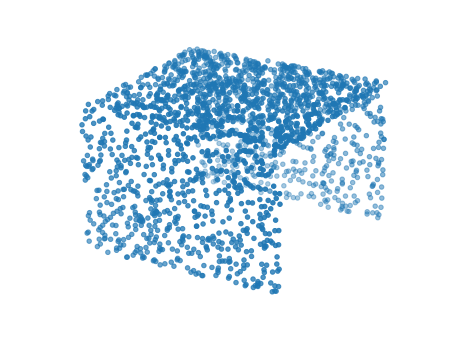

In [ ]:
points = X[15,:,:]
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [ ]:
import csv
import numpy as np
fil_name = 'tableGen'
with open(fil_name+'.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerows(X)